# Hyperparameter Tuning Vertex AI for Image Classification
In this lab you will use hyperparams tuning on Vertex AI to train and tune an Image Classification model.

Learning Objectives:
* Learn how to develop an efficient ingest pipeline for images serialized to TFRecords with `tf.data`
* Learn how to configure a training application for Vertex AI Hyperparameter Tuning
* Learn how to launch a hyperparameter tuning job

## Setup 

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
from google.cloud import aiplatform
from google.cloud.aiplatform import hyperparameter_tuning as hpt

# silence TF info logs
%env TF_CPP_MIN_LOG_LEVEL=3

print(tf.__version__)

env: TF_CPP_MIN_LOG_LEVEL=3
2.8.3


In [2]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT + "-flowers"
TRAIN_DATA_PATH = f"gs://{BUCKET}/data/train*"
EVAL_DATA_PATH = f"gs://{BUCKET}/data/eval*"
REGION = "us-central1"
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

%env BUCKET={BUCKET}
%env PROJECT={PROJECT}
%env REGION={REGION}

env: BUCKET=kylesteckler-instructor-flowers
env: PROJECT=kylesteckler-instructor
env: REGION=us-central1


Make sure the data is available. 

In [3]:
!gsutil ls {TRAIN_DATA_PATH}

gs://kylesteckler-instructor-flowers/data/train.tfrecord-00000-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00001-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00002-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00003-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00004-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00005-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00006-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00007-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00008-of-00010
gs://kylesteckler-instructor-flowers/data/train.tfrecord-00009-of-00010


In [4]:
!gsutil ls {EVAL_DATA_PATH}

gs://kylesteckler-instructor-flowers/data/eval.tfrecord-00000-of-00003
gs://kylesteckler-instructor-flowers/data/eval.tfrecord-00001-of-00003
gs://kylesteckler-instructor-flowers/data/eval.tfrecord-00002-of-00003


**NOTE** If you do not see any data or get an error, you can create this bucket and data by running the cells in the **Data Setup** section, or by completing the lab `creating_tfrecords_at_scale.ipynb`.

#### Data Setup

If you see the `.tfrecord` files listed from the above `gsutil ls` command, you may skip this section.

The next two cells make sure your bucket exists (or creates it) then copies the `.tfrecord` files to your bucket. This bucket and files are alternatively created in the lab `create_tfrecords_at_scale.ipynb`

Make sure bucket exists and if not, create it.

In [ ]:
%%bash
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
  echo -e "Bucket gs://${BUCKET} already exists."
    
else
   echo "Creating a new GCS bucket."
   gsutil mb -l ${REGION} gs://${BUCKET}
   echo -e "\nHere are your current buckets:"
   gsutil ls
fi

Copy data to your bucket

In [ ]:
!gsutil -m cp gs://asl-public/data/flowers/tfrecords/* gs://{BUCKET}/data/

Make sure the data is available

In [ ]:
!gsutil ls {TRAIN_DATA_PATH}

In [ ]:
!gsutil ls {EVAL_DATA_PATH}

#### Create `tf.data` pipeline to ingest data

#### Data Ingest Pipeline
We can build a quite sophisticated ingest pipeline with two simple functions. We need a `create_dataset` function that returns a `tf.data` Dataset, and a `parse_example` function that parses each serialized Example.

The `create_dataset` function does the following:
* Gets a list of filenames that match a given pattern with `tf.io.gfile.glob`
* Instantiates a `tf.data.TFRecordDataset` with the list of filenames
* Maps a parsing function to each example
* Configures for performance with caching, shuffling, batching, and prefetching

The `parse_example` function does the following:
* Parses a single example using the `feature_description`
* Decodes the image with `tf.io.decode_jpeg`
* Resizes the image to specified shape (remember, all examples we feed through a neural network must have the same shape)
* Returns the image and the label

In [5]:
def parse_example(example, img_shape):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.io.decode_jpeg(example["image"], channels=3)
    return tf.image.resize(img, img_shape[:-1]) / 255.0, example["label"]


def create_dataset(pattern, batch_size, img_shape, mode="train"):
    AUTOTUNE = tf.data.AUTOTUNE
    filenames = tf.io.gfile.glob(pattern)  # List of files matching pattern
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(
        lambda x: parse_example(x, img_shape=img_shape),
        num_parallel_calls=AUTOTUNE,
    )

    # Configure for performance
    ds = ds.cache()
    if mode == "train":
        ds = ds.shuffle(buffer_size=10 * batch_size).repeat()
    else:
        ds = ds.repeat(1)

    return ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

#### Validate data ingest pipeline
Ingest and inspect an example from both training and validation

Example from training set:
Shape: (1, 256, 256, 3)
Label: dandelion


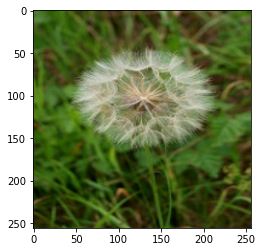

In [6]:
temp_train_ds = create_dataset(
    TRAIN_DATA_PATH, batch_size=1, img_shape=[256, 256, 3]
)
temp_val_ds = create_dataset(
    EVAL_DATA_PATH, batch_size=1, img_shape=[256, 256, 3], mode="test"
)

for img, label in temp_train_ds.take(1):
    print("Example from training set:")
    print(f"Shape: {img.shape}")
    print(f"Label: {CLASSES[int(label.numpy())]}")
    plt.imshow(tf.squeeze(img.numpy(), axis=0))

Example from validation set:
Shape: (1, 256, 256, 3)
Label: sunflowers


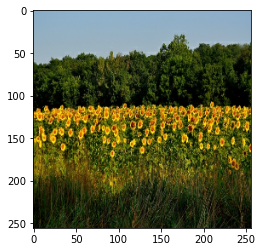

In [7]:
for img, label in temp_val_ds.take(1):
    print("Example from validation set:")
    print(f"Shape: {img.shape}")
    print(f"Label: {CLASSES[int(label.numpy())]}")
    plt.imshow(tf.squeeze(img.numpy(), axis=0))

#### Bundle code together for Vertex AI Hyperparameter Tuning
The steps to launch a hyperparameter tuning job with Vertex AI are:
* Make the hyperparameters you want to tune for command line arguments
* Report the metric you want to optimize with `hpt.report_hyperparameter_tuning_metric`
* Build and push containerized training application 
* Configure StudySpec for Vertex AI Hyperparameter Tuning
* Launch hyperparameter tuning job

In [8]:
!mkdir ./flower_trainer

mkdir: cannot create directory ‘./flower_trainer’: File exists


In [9]:
%%writefile ./flower_trainer/train.py

import tensorflow as tf 
import fire 
import hypertune
import tensorflow_hub as hub

def parse_example(example, img_shape):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.io.decode_jpeg(example["image"], channels=3)
    
    # resize and scale
    return tf.image.resize(img, img_shape[:-1])/255.0, example["label"]

def create_dataset(pattern, batch_size, img_shape, mode='train'):
    AUTOTUNE = tf.data.AUTOTUNE

    filenames = tf.io.gfile.glob(pattern) # List of files matching pattern
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(lambda x: parse_example(x, img_shape=img_shape), num_parallel_calls=AUTOTUNE)
    
    # Configure for performance
    ds = ds.cache()
    if mode=='train':
        ds = ds.shuffle(buffer_size=10*batch_size).repeat()
    else:
        ds = ds.repeat(1)
    
    return ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

def build_hub_model(
    input_shape,
    dense_units,
    dropout,
    num_classes,
    module_handle
):
    
    inputs = tf.keras.layers.Input(shape=input_shape) # [height, width, channels]
    
    # Pre-trained model from tfhub 
    # trainable=False means frozen weights 
    hub_layer = hub.KerasLayer(module_handle, trainable=False)(inputs)
    
    # Additional learned dense layer 
    dense_layer = tf.keras.layers.Dense(dense_units, activation="relu")(hub_layer)
    x = tf.keras.layers.Dropout(dropout)(dense_layer)
    
    # Output the logits 
    output = tf.keras.layers.Dense(num_classes)(x)
    
    # Instantiate keras model
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    return model 
    

def train_evaluate(
    train_data_path,
    eval_data_path,
    batch_size,
    num_steps,
    num_evals,
    img_shape=[224,224,3],
    dense_units=16,
    dropout=0.1,
    num_classes=5,
    module_handle="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
    hptune=True,
    output_dir=None
):
    
    train_ds = create_dataset(train_data_path, batch_size=batch_size, img_shape=img_shape)
    val_ds = create_dataset(eval_data_path, batch_size=64, img_shape=img_shape,mode='test')

    steps_per_epoch = num_steps // (num_evals * batch_size)
    
    # Build model 
    model = build_hub_model(
        input_shape=img_shape,
        dense_units=dense_units,
        dropout=dropout,
        num_classes=num_classes,
        module_handle=module_handle
    )
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_evals,
        steps_per_epoch=steps_per_epoch,
        verbose=2
    )
    
    # report metric if tuning
    if hptune:
        hp_metric = history.history['val_accuracy'][-1]
        hpt = hypertune.HyperTune()
        hpt.report_hyperparameter_tuning_metric(
            hyperparameter_metric_tag='accuracy',
            metric_value=hp_metric,
            global_step=num_evals
        )
     
    # save final model if not tuning
    else:
        model.save(output_dir)

if __name__ == '__main__':
    fire.Fire(train_evaluate)
    

Overwriting ./flower_trainer/train.py


#### Containerize training application

Write Dockerfile then build and push your image with `gcloud builds submit`

In [10]:
%%writefile ./flower_trainer/Dockerfile
FROM gcr.io/deeplearning-platform-release/tf2-gpu.2-7

# Installs hypertune library and fire 
RUN pip install -U cloudml-hypertune fire

# Copies the trainer code to the docker image.
WORKDIR /app
COPY train.py .

# Sets up the entry point to invoke the trainer.
ENTRYPOINT ["python", "train.py"]

Overwriting ./flower_trainer/Dockerfile


In [11]:
IMAGE_NAME = "flowers_trainer_tf"
TAG = "latest"
TRAINING_CONTAINER_IMAGE_URI = f"gcr.io/{PROJECT}/{IMAGE_NAME}:{TAG}"
TRAINING_CONTAINER_IMAGE_URI

'gcr.io/kylesteckler-instructor/flowers_trainer_tf:latest'

In [12]:
!gcloud builds submit --machine-type=e2-highcpu-32 --timeout=15m --tag $TRAINING_CONTAINER_IMAGE_URI flower_trainer

Creating temporary tarball archive of 2 file(s) totalling 3.6 KiB before compression.
Uploading tarball of [flower_trainer] to [gs://kylesteckler-instructor_cloudbuild/source/1662739015.905362-df781b7cb7054958b2240bd61d64b076.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/kylesteckler-instructor/locations/global/builds/ad4742b4-b219-4931-bcb2-de55841a2a69].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/ad4742b4-b219-4931-bcb2-de55841a2a69?project=335831560329 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "ad4742b4-b219-4931-bcb2-de55841a2a69"

FETCHSOURCE
Fetching storage object: gs://kylesteckler-instructor_cloudbuild/source/1662739015.905362-df781b7cb7054958b2240bd61d64b076.tgz#1662739016085040
Copying gs://kylesteckler-instructor_cloudbuild/source/1662739015.905362-df781b7cb7054958b2240bd61d64b076.tgz#1662739016085040...
/ [1 files][  1.7 KiB/  1.7 KiB]                                    

#### Configure Vertex AI Hyperparameter Tuning Job
There are configurations we need to provide Vertex AI with to launch a Hyperparameter Tuning job.

`worker_pool_specs` specifies the hardware and training application to run for each trial of the hyperparameter tuning job. `worker_pool_spec` is composed of `machine_spec` and `container_spec`. `machine_spec` defines the machine type you want Vertex to use, as well as (optionally) accelerator type and count. `container_spec` specifies the image URI of the containerized training application, as well as any arguments to pass along to it. Note: You only provide the arguments you are not hyperparameter tuning for.

`metric_spec` specifies the metric tag you want to optimize for as well as the optimization goal (minimize or maximize).

`parameter_spec` specifies the parameters you want to tune for as well as constaints for tuning them.

In [13]:
# Specify variables used to configure hyperparameter tuning job
TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")

DISPLAY_NAME = "flower-classifier-hyperparam-tuning-job"
MAX_TRIAL_COUNT = 10
MAX_PARALLEL_TRIALS = 5
JOB_NAME = f"flower-classifier-custom-training-{TIMESTAMP}"
BUCKET = f"gs://{PROJECT}-flowers"
NUM_STEPS = 10000
NUM_EVALS = 10

In [14]:
# Define required specifications
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-16",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAINING_CONTAINER_IMAGE_URI,
            "args": [
                f"--train_data_path={TRAIN_DATA_PATH}",
                f"--eval_data_path={EVAL_DATA_PATH}",
                f"--num_steps={NUM_STEPS}",
                f"--num_evals={NUM_EVALS}",
            ],
        },
    }
]

metric_spec = {"accuracy": "maximize"}

parameter_spec = {
    "batch_size": hpt.IntegerParameterSpec(min=16, max=128, scale="log"),
    "dense_units": hpt.DiscreteParameterSpec(values=[64, 128, 256], scale=None),
    "dropout": hpt.DoubleParameterSpec(min=0.05, max=0.4, scale="linear"),
}

custom_job = aiplatform.CustomJob(
    display_name=JOB_NAME,
    project=PROJECT,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=BUCKET,
)

# Create hyperparam tuning job
hp_job = aiplatform.HyperparameterTuningJob(
    display_name=JOB_NAME,
    custom_job=custom_job,
    metric_spec=metric_spec,
    parameter_spec=parameter_spec,
    max_trial_count=MAX_TRIAL_COUNT,
    parallel_trial_count=MAX_PARALLEL_TRIALS,
    project=PROJECT,
    search_algorithm=None,
)

hp_job.run(sync=False)

INFO:google.cloud.aiplatform.jobs:Creating HyperparameterTuningJob
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob created. Resource name: projects/335831560329/locations/us-central1/hyperparameterTuningJobs/6001353542093242368
INFO:google.cloud.aiplatform.jobs:To use this HyperparameterTuningJob in another session:
INFO:google.cloud.aiplatform.jobs:hpt_job = aiplatform.HyperparameterTuningJob.get('projects/335831560329/locations/us-central1/hyperparameterTuningJobs/6001353542093242368')
INFO:google.cloud.aiplatform.jobs:View HyperparameterTuningJob:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/6001353542093242368?project=335831560329
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/335831560329/locations/us-central1/hyperparameterTuningJobs/6001353542093242368 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:HyperparameterTuningJob projects/335831560329/locations/us-central1/hyperparameterTuningJobs/

**NOTE** The job takes about 25 minutes to complete. Once the job is completed you can query the results and see metrics across the different trials.

In [15]:
for trial in hp_job.trials:
    print(f"Trial #{trial.id}")
    for param in trial.parameters:
        print(f"{param.parameter_id}: {param.value}")
    print(
        f"{trial.final_measurement.metrics[0].metric_id}: {trial.final_measurement.metrics[0].value}\n"
    )

Trial #1
batch_size: 72.0
dense_units: 128.0
dropout: 0.22500000000000003
accuracy: 0.8765432238578796

Trial #2
batch_size: 47.0
dense_units: 64.0
dropout: 0.14976746754801637
accuracy: 0.8834019303321838

Trial #3
batch_size: 45.0
dense_units: 64.0
dropout: 0.22521840265198179
accuracy: 0.8930041193962097

Trial #4
batch_size: 75.0
dense_units: 128.0
dropout: 0.31093042776755947
accuracy: 0.8875171542167664

Trial #5
batch_size: 25.0
dense_units: 128.0
dropout: 0.3157850063873344
accuracy: 0.8971193432807922

Trial #6
batch_size: 16.0
dense_units: 64.0
dropout: 0.3963676063066271
accuracy: 0.8683127760887146

Trial #7
batch_size: 16.0
dense_units: 128.0
dropout: 0.2778196566389398
accuracy: 0.8628258109092712

Trial #8
batch_size: 18.0
dense_units: 256.0
dropout: 0.34538065124940004
accuracy: 0.8875171542167664

Trial #9
batch_size: 92.0
dense_units: 64.0
dropout: 0.05
accuracy: 0.8984910845756531

Trial #10
batch_size: 128.0
dense_units: 128.0
dropout: 0.4
accuracy: 0.87791496515274

Congrats! You've succesfully:
* Created a custom image classification model configured for Vertex AI Hyperparameter Tuning
* Built and pushed the training application as a Docker image
* Launched a Hyperparameter Tuning Job on Vertex AI 